<a href="https://colab.research.google.com/github/sukantsaumya/SoilHealthPrediction/blob/main/DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
hsi_path = '/content/1570.npz'
gt_path = '/content/drive/MyDrive/DL/train_data/train_data/train_gt.csv'
wavelength_path = '/content/drive/MyDrive/DL/train_data/train_data/wavelengths.csv'

In [ ]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

In [ ]:
gt_df[gt_df['sample_index']==1570]


,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


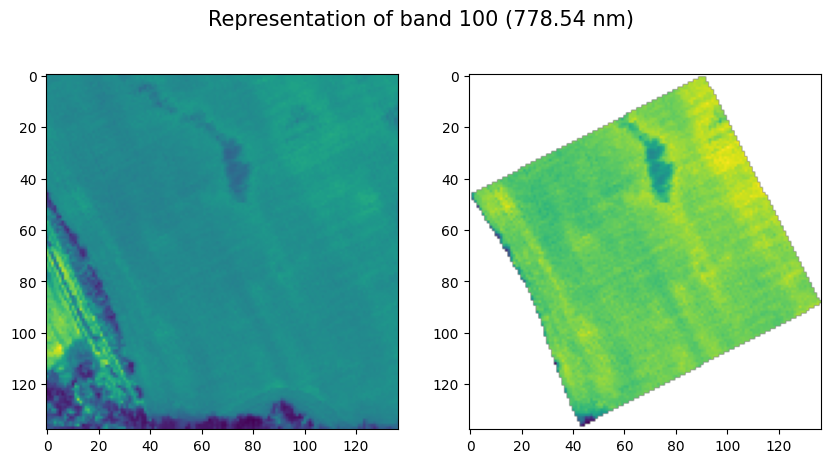

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

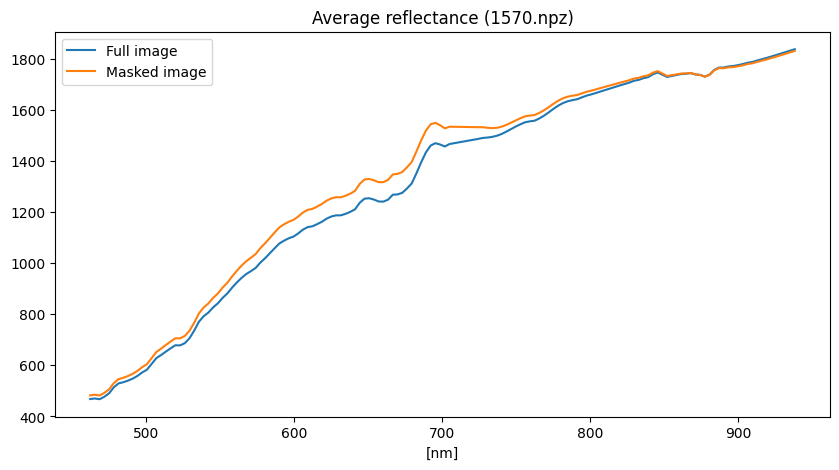

In [ ]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

In [ ]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [ ]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("/content/drive/MyDrive/DL/train_data/train_data/train_data")
y_train = load_gt("/content/drive/MyDrive/DL/train_data/train_data/train_gt.csv")
X_test = load_data("/content/drive/MyDrive/DL/test_data/test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [ ]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

In [ ]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9896068600445717
Class K score: 1.004900913045855
Class Mg score: 1.0228518828521695
Class pH score: 1.6431314552511207
Final score: 1.1651227777984292


Original sample data:
     P    K   Mg   pH
0    8   80   30  4.2
1   20  140   80  6.0
2   40  280  160  6.5
3  120  400  220  8.0


Classified soil data:
     P    K   Mg   pH    P_class    K_class   Mg_class   pH_class  \
0    8   80   30  4.2       Poor       Poor       Poor       Poor   
1   20  140   80  6.0   Moderate   Moderate   Moderate  Excellent   
2   40  280  160  6.5       Good  Excellent  Excellent  Excellent   
3  120  400  220  8.0  Excellent  Excellent  Excellent   Moderate   

   health_score overall_health  
0          1.00           Poor  
1          2.50       Moderate  
2          3.75      Excellent  
3          3.50           Good  




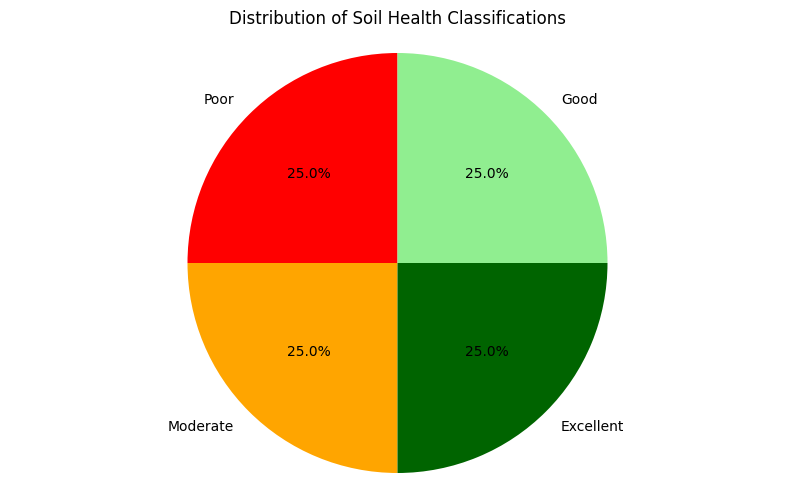


SOIL HEALTH REPORT - SAMPLE #0

OVERALL HEALTH: Poor (Score: 1.00/4.00)

PARAMETER BREAKDOWN:
- Phosphorus (P): 8.00 mg/kg - Poor
- Potassium (K): 80.00 mg/kg - Poor
- Magnesium (Mg): 30.00 mg/kg - Poor
- pH: 4.20 - Poor

RECOMMENDATIONS:
1. Apply phosphorus fertilizer. Consider rock phosphate or bone meal for organic options.
2. Apply potassium fertilizer. Consider potassium sulfate or wood ash for organic options.
3. Apply magnesium. Consider dolomitic lime or Epsom salts.
4. Soil is acidic (pH 4.2). Apply lime to raise pH.

NOTE: These recommendations are based on spectral analysis and should be
confirmed with traditional soil tests before making major management decisions.

SOIL HEALTH REPORT - SAMPLE #1

OVERALL HEALTH: Moderate (Score: 2.50/4.00)

PARAMETER BREAKDOWN:
- Phosphorus (P): 20.00 mg/kg - Moderate
- Potassium (K): 140.00 mg/kg - Moderate
- Magnesium (Mg): 80.00 mg/kg - Moderate
- pH: 6.00 - Excellent

RECOMMENDATIONS:
1. Moderate phosphorus application recommended to 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class SoilHealthClassifier:
    """
    Classifies soil health based on P, K, Mg, and pH values.
    """

    def __init__(self):
        # Define thresholds for each parameter
        self.thresholds = {
            'P': {'poor': 10, 'moderate': 25, 'good': 50, 'excellent': 100},
            'K': {'poor': 100, 'moderate': 150, 'good': 250, 'excellent': 350},
            'Mg': {'poor': 50, 'moderate': 100, 'good': 150, 'excellent': 200},
            'pH': {
                'poor_low': 4.5, 'moderate_low': 5.5,
                'good_low': 6.0, 'good_high': 7.0,
                'moderate_high': 7.5, 'poor_high': 8.5
            }
        }

    def classify_parameter(self, value, param):
        """Classify a single parameter value"""
        if param == 'pH':
            if value < self.thresholds[param]['poor_low'] or value > self.thresholds[param]['poor_high']:
                return 'Poor'
            elif value < self.thresholds[param]['moderate_low'] or value > self.thresholds[param]['moderate_high']:
                return 'Moderate'
            elif value < self.thresholds[param]['good_low'] or value > self.thresholds[param]['good_high']:
                return 'Good'
            else:
                return 'Excellent'
        else:
            if value < self.thresholds[param]['poor']:
                return 'Poor'
            elif value < self.thresholds[param]['moderate']:
                return 'Moderate'
            elif value < self.thresholds[param]['good']:
                return 'Good'
            else:
                return 'Excellent'

    def classify_soil(self, soil_data):
        """
        Classify soil health based on all parameters.
        """
        if isinstance(soil_data, np.ndarray):
            soil_df = pd.DataFrame(soil_data, columns=['P', 'K', 'Mg', 'pH'])
        else:
            soil_df = soil_data.copy()

        # Classify each parameter
        for param in ['P', 'K', 'Mg', 'pH']:
            soil_df[f'{param}_class'] = soil_df[param].apply(lambda x: self.classify_parameter(x, param))

        # Calculate overall health score (1=Poor, 2=Moderate, 3=Good, 4=Excellent)
        class_map = {'Poor': 1, 'Moderate': 2, 'Good': 3, 'Excellent': 4}

        # Convert classifications to numeric scores
        for param in ['P', 'K', 'Mg', 'pH']:
            soil_df[f'{param}_score'] = soil_df[f'{param}_class'].map(class_map)

        # Overall score is the average of individual scores
        soil_df['health_score'] = soil_df[[f'{param}_score' for param in ['P', 'K', 'Mg', 'pH']]].mean(axis=1)

        # Convert numeric score back to classification
        def score_to_health(score):
            if score < 1.75:
                return 'Poor'
            elif score < 2.75:
                return 'Moderate'
            elif score < 3.75:
                return 'Good'
            else:
                return 'Excellent'

        soil_df['overall_health'] = soil_df['health_score'].apply(score_to_health)

        return soil_df

    def plot_health_distribution(self, classified_data):
        """Generate pie chart showing distribution of soil health classifications"""
        health_counts = classified_data['overall_health'].value_counts()

        plt.figure(figsize=(10, 6))
        colors = {'Poor': 'red', 'Moderate': 'orange', 'Good': 'lightgreen', 'Excellent': 'darkgreen'}
        plot_colors = [colors[cat] for cat in health_counts.index]

        plt.pie(health_counts, labels=health_counts.index, autopct='%1.1f%%',
                startangle=90, colors=plot_colors)
        plt.axis('equal')
        plt.title('Distribution of Soil Health Classifications')
        plt.show()

    def generate_recommendations(self, soil_data_row):
        """Generate recommendations based on soil health classification"""
        recommendations = []

        # Check P levels
        if soil_data_row['P_class'] == 'Poor':
            recommendations.append("Apply phosphorus fertilizer. Consider rock phosphate or bone meal for organic options.")
        elif soil_data_row['P_class'] == 'Moderate':
            recommendations.append("Moderate phosphorus application recommended to build soil reserves.")

        # Check K levels
        if soil_data_row['K_class'] == 'Poor':
            recommendations.append("Apply potassium fertilizer. Consider potassium sulfate or wood ash for organic options.")
        elif soil_data_row['K_class'] == 'Moderate':
            recommendations.append("Moderate potassium application recommended to improve soil fertility.")

        # Check Mg levels
        if soil_data_row['Mg_class'] == 'Poor':
            recommendations.append("Apply magnesium. Consider dolomitic lime or Epsom salts.")
        elif soil_data_row['Mg_class'] == 'Moderate':
            recommendations.append("Add moderate amounts of magnesium to improve soil structure and nutrient availability.")

        # Check pH levels
        if soil_data_row['pH'] < 5.5:
            recommendations.append(f"Soil is acidic (pH {soil_data_row['pH']:.1f}). Apply lime to raise pH.")
        elif soil_data_row['pH'] > 7.5:
            recommendations.append(f"Soil is alkaline (pH {soil_data_row['pH']:.1f}). Add sulfur or organic matter to lower pH.")

        if len(recommendations) == 0:
            recommendations.append("Soil is in good health. Continue current management practices.")

        return recommendations

    def soil_health_report(self, classified_df, sample_idx=0):
        """Generate a comprehensive soil health report for a sample"""
        sample = classified_df.iloc[sample_idx]

        print("\n" + "="*50)
        print(f"SOIL HEALTH REPORT - SAMPLE #{sample_idx}")
        print("="*50)

        print(f"\nOVERALL HEALTH: {sample['overall_health']} (Score: {sample['health_score']:.2f}/4.00)")
        print("\nPARAMETER BREAKDOWN:")
        print(f"- Phosphorus (P): {sample['P']:.2f} mg/kg - {sample['P_class']}")
        print(f"- Potassium (K): {sample['K']:.2f} mg/kg - {sample['K_class']}")
        print(f"- Magnesium (Mg): {sample['Mg']:.2f} mg/kg - {sample['Mg_class']}")
        print(f"- pH: {sample['pH']:.2f} - {sample['pH_class']}")

        print("\nRECOMMENDATIONS:")
        recommendations = self.generate_recommendations(sample)
        for i, rec in enumerate(recommendations):
            print(f"{i+1}. {rec}")

        print("\nNOTE: These recommendations are based on spectral analysis and should be")
        print("confirmed with traditional soil tests before making major management decisions.")
        print("="*50)

        return sample

# Create sample data to test the classifier
# This can be replaced with your actual submission data
sample_data = pd.DataFrame({
    'P': [8, 20, 40, 120],
    'K': [80, 140, 280, 400],
    'Mg': [30, 80, 160, 220],
    'pH': [4.2, 6.0, 6.5, 8.0]
})

print("Original sample data:")
print(sample_data)
print("\n")

# Create and apply the classifier
classifier = SoilHealthClassifier()
classified_data = classifier.classify_soil(sample_data)

print("Classified soil data:")
print(classified_data[['P', 'K', 'Mg', 'pH', 'P_class', 'K_class', 'Mg_class', 'pH_class', 'health_score', 'overall_health']])
print("\n")

# Generate health distribution chart
classifier.plot_health_distribution(classified_data)

# Generate detailed reports for each sample
for i in range(len(classified_data)):
    classifier.soil_health_report(classified_data, i)

print("\nTo use with your actual predictions, replace 'sample_data' with your predictions dataframe.")
print("For example: classified_data = classifier.classify_soil(submission)")

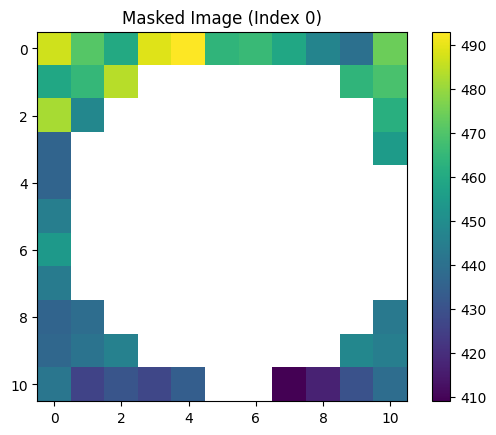

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
npz = np.load('/content/drive/MyDrive/DL/train_data/train_data/train_data/0.npz')
data = npz['data']
mask = npz['mask']

# Step 3: Apply the mask to one image (e.g., first one)
masked_img = np.where(mask[0], data[0], np.nan)

# Step 4: Display and save the image
plt.imshow(masked_img, cmap='viridis')
plt.colorbar()
plt.title('Masked Image (Index 0)')
plt.savefig('masked_image_0.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


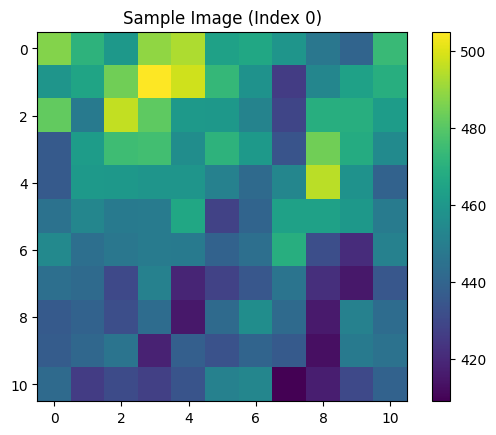

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npz file (replace with your filename if different)
npz = np.load('/content/drive/MyDrive/DL/train_data/train_data/train_data/0.npz')

data = npz['data']  # shape: (150, 11, 11)

# Pick an index (e.g., 0)
img = data[0]

# Plot the image
plt.imshow(img, cmap='viridis')  # or 'gray', 'plasma', etc.
plt.colorbar()
plt.title('Sample Image (Index 0)')
plt.show()
